https://huggingface.co/albert/albert-base-v2

### Install libraries

In [ ]:
!pip install -q transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
import torch
import random
import numpy as np

torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
np.random.seed(7)
random.seed(7)

## Import dataset

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

import pickle
with open("dict_dataset.pkl", "rb") as myFile:
    dict_dataset = pickle.load(myFile)

print(dict_dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'domain', '__index_level_0__'],
        num_rows: 27076
    })
    validation: Dataset({
        features: ['text', 'label', 'domain', '__index_level_0__'],
        num_rows: 6769
    })
    test: Dataset({
        features: ['text', 'label', 'domain'],
        num_rows: 21832
    })
})


In [ ]:
NUM_LABELS = len(dict_dataset['train'].unique('label'))
LABELS = ['generated', 'human']  # 'generated': 0, 'human': 1

## Tokenize
Load the tokenizer associated to BERT base.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Since BERT only allows 512 tokens as input size, let's see the size of our dataset:

In [ ]:
MAX_LENGTH= max([len(tokenizer(text).input_ids) for text in dict_dataset['train']['text']])
print("Maximum length", MAX_LENGTH)

Maximum length 168


Tokenize by batches

In [ ]:
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length",max_length=MAX_LENGTH)
    # return tokenizer(examples, padding="longest")

In [ ]:
encoded_data = dict_dataset.map(tokenize, batched=True)
encoded_data

Map:   0%|          | 0/27076 [00:00<?, ? examples/s]

Map:   0%|          | 0/6769 [00:00<?, ? examples/s]

Map:   0%|          | 0/21832 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'domain', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27076
    })
    validation: Dataset({
        features: ['text', 'label', 'domain', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6769
    })
    test: Dataset({
        features: ['text', 'label', 'domain', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21832
    })
})

Let's see some text examples.

In [ ]:
import random
for i in range(10):
    index = random.randint(0,encoded_data['train'].num_rows)
    print('text:', index, ' len:', len(encoded_data['train'][index]['input_ids']))  # input_ids represents each word to their corresponding ID within the tokenizer's vocabulary

text: 10611  len: 168
text: 4943  len: 168
text: 12937  len: 168
text: 21329  len: 168
text: 1582  len: 168
text: 2373  len: 168
text: 26911  len: 168
text: 17559  len: 168
text: 3084  len: 168
text: 11982  len: 168


## Fine-tuning pre-trained model

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=NUM_LABELS)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Hyperparameters


ner of epochs, batch size, learning rate, etc.


Set TrainingArguments object that contains all default parameters.

In [ ]:
from transformers import TrainingArguments
args = TrainingArguments(output_dir="./outputs")
args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=None,
group_by_length=False,
half_precision_backend=au

Modify some of these parameters:

In [ ]:
args.per_device_train_batch_size = 32
args.per_device_eval_batch_size = 32
args.evaluation_strategy="epoch"
# args.evaluation_strategy="step"
# args.learning_rate=5e-05

### Metrics

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = pred.predictions.argmax(-1)

    acc = accuracy_score(y_true, y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Trainer

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    train_dataset = encoded_data['train'],
    eval_dataset = encoded_data['validation'],

    args = args,     # hyperparameters
    compute_metrics=compute_metrics,    # metrics
)

#### Train

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.449400,0.380923,0.848279,0.845244,0.875228,0.847310
2,0.191100,0.234465,0.922736,0.922735,0.922884,0.922812
3,0.072400,0.309322,0.928793,0.928790,0.928788,0.928791


TrainOutput(global_step=2541, training_loss=0.21601414314549253, metrics={'train_runtime': 2739.3063, 'train_samples_per_second': 29.653, 'train_steps_per_second': 0.928, 'total_flos': 636954612577920.0, 'train_loss': 0.21601414314549253, 'epoch': 3.0})

#### Evaluate with Validation dataset

In [ ]:
trainer.evaluate()

{'eval_loss': 0.3093222379684448,
 'eval_accuracy': 0.9287930270350125,
 'eval_f1': 0.9287895939057931,
 'eval_precision': 0.9287879155610443,
 'eval_recall': 0.9287914344382517,
 'eval_runtime': 75.0913,
 'eval_samples_per_second': 90.144,
 'eval_steps_per_second': 2.823,
 'epoch': 3.0}

We get an overall f1-score of 0.93.

#### Save and access model

In [ ]:
# Save model to local folder
trainer.save_model("/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/albert_base_v2")

In [ ]:
# Load Hugging Face credentials
import json
with open('config.json') as f:
    config = json.load(f)

# Access model
from transformers import AutoModelForSequenceClassification
# from local folder
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/albert_base_v2")

# Push model to Hugging Face Hub
from huggingface_hub import notebook_login
notebook_login()
model.push_to_hub(repo_id="luciayn/albert_base_v2", token=config['hf_token'])
tokenizer.push_to_hub(repo_id="luciayn/albert_base_v2", token=config['hf_token'])

from transformers import AutoModelForSequenceClassification
# access model from Hugging Face Hub
model = AutoModelForSequenceClassification.from_pretrained("luciayn/albert_base_v2")

model.safetensors:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/946 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
# access model from Hugging Face Hub
model = AutoModelForSequenceClassification.from_pretrained("luciayn/albert_base_v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/946 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

In [ ]:
model.to('cuda')

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

## Evaluation

Create a function that tokenizes the input text and apply the trained model. Then the softmax function is applied to calculate the probabilities of the classes, and returns the greatest one.


In [ ]:
def get_prediction(text):
    # prepara el texto, aplicamos la misma tokenización que la utilizada en el training
    inputs = tokenizer(text, padding="max_length", max_length=MAX_LENGTH, truncation= True, return_tensors="pt").to("cuda")

    # aplicamos el modelo
    pred = model(**inputs).logits

    # obtenemos la probabilidad para cada clase
    probs = pred.softmax(1)
    # devolvemos la mayor
    return probs.argmax().item()

In [ ]:
# Predict class for each text in the test dataset
y_pred=[get_prediction(text) for text in dict_dataset['test']['text']]
y_true = dict_dataset['test']['label']

In [ ]:
# Show the precision, recall, and f1-score of the predictions
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=LABELS))

              precision    recall  f1-score   support

   generated       0.70      0.97      0.82     11190
       human       0.95      0.57      0.71     10642

    accuracy                           0.77     21832
   macro avg       0.83      0.77      0.76     21832
weighted avg       0.82      0.77      0.76     21832



We get a f1-score of 0.82 for the generated class, and 0.71 for the human class.
Moreover, we obtain an macro f1-score of 0.76.

[[10889   301]
 [ 4616  6026]]


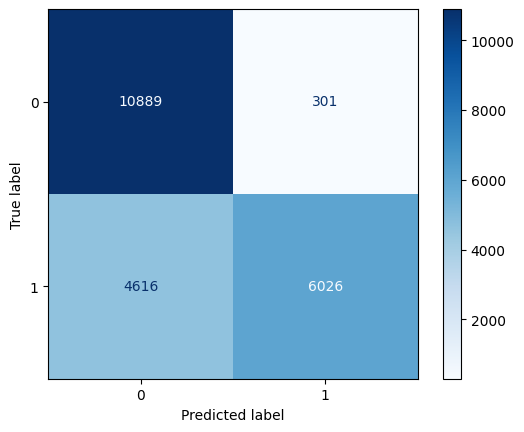

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_true, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues)